# Includes

In [78]:
import os
import sys
import time
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.utils
import torch.nn.functional as F
import torchvision.datasets as dset
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torch.autograd import Variable
from timeit import default_timer as timer
from tqdm import tqdm
from collections import defaultdict,Counter

import scipy.io

In [79]:
!pip install optuna
import optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
cd drive/

[Errno 2] No such file or directory: 'drive/'
/content/drive/MyDrive/Colab Notebooks/huawei


In [82]:
cd /content/drive/MyDrive/Colab Notebooks/huawei

/content/drive/MyDrive/Colab Notebooks/huawei


In [83]:
from DPDBlocks.blocks import AFIR,ABS,Polynomial,Delay,Prod_cmp

In [84]:
import matplotlib.pyplot as plt

import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec

# Operations

In [85]:
def NMSE(X, E):
    return 10*torch.log10((E.norm(dim=1)**2).sum()/(X.norm(dim=1)**2).sum())

In [86]:
def update_history(hist,iter_num, val_acc, val_loss, time):
    hist['iter'].append(iter_num)
    hist['time'].append(time)
    hist['train_loss'].append(val_loss.item())
        # self.hist['norm_coeffs'].append(train_loss.item())
    hist['train_loss_db'].append(val_acc.item())

In [87]:
def draw_spectrum(input_batch,desired,out):
  plt.psd(input_batch.detach().cpu()[0,0,:]+
                1j*input_batch.detach().cpu()[0,1,:],NFFT=2048)
  plt.psd(desired.detach().cpu()[0,0,:]+
                1j*desired.detach().cpu()[0,1,:],NFFT=2048)
        # plt.psd(desired.permute(2,1,0).detach().cpu().reshape(-1,),NFFT=2048)
  plt.psd((out-desired).detach().cpu()[0,0,:]+
                1j*(out-desired).detach().cpu()[0,1,:],NFFT=2048)
        # plt.psd((out-desired).permute(2,1,0).detach().cpu().reshape(-1,),NFFT=2048)
  plt.show()

## Train Function

In [88]:
def eval_model(valid_queue, model, criterion):
    for step, (valid) in enumerate(valid_queue):
        model.eval()
        input_batch = Variable(valid[:,:,:1],requires_grad=False).permute(2,1,0).cpu()
        desired = Variable(valid[:,:,1:],requires_grad=False).permute(2,1,0).cpu()
        out = model.forward(input_batch)
        #out_0 = sum(list(map( lambda m: m(input_batch),  model[0])))
        #out = sum(list(map( lambda n: n(out_0),  model[1])))

        loss=criterion(out,desired)


        #draw_spectrum(input_batch,desired,out)
        accuracy = NMSE(input_batch, out - desired)

    return loss,accuracy

In [89]:
from numpy import gradient


def train_of_epoch(train_queue, model, criterion, optimizer):
    for step, (train) in enumerate(train_queue):

        input_batch = Variable(train[:,:,:1],requires_grad=False).permute(2,1,0).cpu()
        desired = Variable(train[:,:,1:],requires_grad=False).permute(2,1,0).cpu()
        optimizer.zero_grad()
        out = model.forward(input_batch)
        #out_0 = sum(list(map( lambda m: m(input_batch),  model[0])))
        #out = sum(list(map( lambda n: n(out_0),  model[1])))

        loss = criterion(out, desired)
    
        loss.backward()
        #print(loss.grad_fn)
        
        optimizer.step()


In [90]:
def train(train_queue, valid_queue, model, criterion, optimizer,n_epoch,
          scheduler,log_every=1,save_flag=True,path_to_experiment=''):
    min_loss=0
    hist=defaultdict(list)
    t0=timer()
    for it in tqdm(range(n_epoch)):
        model.train(True)
        train_of_epoch(train_queue, model, criterion, optimizer)
        scheduler.step()

    #     if return_history and it % log_every == 0:
    #         model.init_for_batch(train)
    #         train_loss = complex_mse(model.forward(train.x), train.y)
        if it%log_every==0:
            loss_v,accuracy_v=eval_model(valid_queue, model, loss_fn)
            update_history(hist,it, accuracy_v, loss_v, timer() - t0,)
            print('Loss = ',loss_v.cpu().detach().numpy(), 'Accuracy = ', accuracy_v.cpu().detach().numpy(), 'dbs')
            
            if save_flag:
                with open(path_to_experiment + '/hist.pkl', 'wb') as output:
                    pickle.dump(hist, output)

                    torch.save(model.state_dict(), path_to_experiment + '/model.pt')
                if hist['train_loss_db'][-1] < min_loss:
                            min_loss = hist['train_loss_db'][-1]
                            torch.save(model.state_dict(), path_to_experiment + '/best_model.pth')



# Data preprocess

In [91]:
np.random.seed()
# torch.cpu.set_device()
torch
cudnn.benchmark = True
torch.manual_seed(10)
# was fixed
cudnn.enabled=False
#torch.cpu.manual_seed(10)

In [92]:
Batch_size=1000

In [93]:
serg_data=np.load('AdaptiveFilteringData/gsm_4c_in.npy').reshape(-1,1)
x_real, x_imag = torch.from_numpy(np.real(serg_data)), torch.from_numpy(np.imag(serg_data))
X = torch.DoubleTensor(torch.cat((x_real, x_imag), dim=1)).reshape(-1,2,1)

In [94]:
name = 'BlackBoxData/BlackBoxData_80'
# name = 'BlackBoxData'
# name = '../BlackBoxData/data1'
mat = scipy.io.loadmat(name)
x = np.array(mat['x']).reshape(-1,1)/2**15
d = np.array(mat['y']).reshape(-1,1)/2**15
# x = np.array(mat['xE']).reshape(-1,1)/2**15
# d = np.array(mat['d']).reshape(-1,1)/2**15
# x, d = mat['xE'], mat['d']
x_real, x_imag = torch.from_numpy(np.real(x)), torch.from_numpy(np.imag(x))
d_real, d_imag = torch.from_numpy(np.real(d)), torch.from_numpy(np.imag(d))
X = torch.DoubleTensor(torch.cat((x_real, x_imag), dim=1)).reshape(-1,2,1)
D = torch.DoubleTensor(torch.cat((d_real, d_imag), dim=1)).reshape(-1,2,1)

train_queue = torch.utils.data.DataLoader(
    torch.cat((X,D),dim=-1), batch_size=Batch_size)#, pin_memory=True)

valid_queue = torch.utils.data.DataLoader(
    torch.cat((X,D),dim=-1), batch_size=X.shape[0])#,pin_memory=True)

In [95]:
gamma=0.95
step_size=5

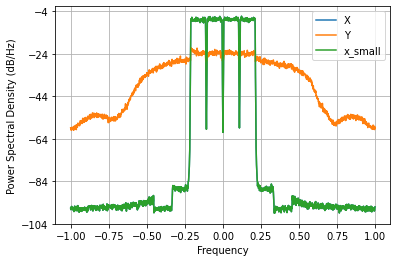

In [96]:
plt.psd(X.detach().cpu()[:,0,0]+1j*X.detach().cpu()[:,1,0],NFFT=2048, label = "X")
plt.psd(d.reshape(-1,),NFFT=2048, label = "Y")
plt.psd(x.reshape(-1,),NFFT=2048, label = "x_small")
plt.legend()
# plt.psd(x.reshape(-1,)*x.reshape(-1,),NFFT=2048)
plt.show()

## Loss function

In [97]:
loss_fn = nn.MSELoss()


In [101]:
from statistics import mode

class Layerr(torch.nn.ModuleList):
    def __init__(self):
        super(Layerr,self).__init__()
        self.L = nn.ModuleList()

    def ap_elem(self, elem : nn.Module):
        self.L.append(elem)

    def forward(self, x):
        #summ = 0
        #for modul in self.L:
        #    summ = summ + modul(x)
        return sum(list(map( lambda m: m(x),  self.L)))
        #return summ


# 2 layer NN
class NN_2_layer(nn.Module):
    def __init__(self, l1, l2):
        super(NN_2_layer, self).__init__()
        self.layer_1 = l1
        self.layer_2 = l2
        #self.model = nn.Sequential(self.layer_1, self.layer_2)
    def forward(self, x):
        return self.layer_2.forward(self.layer_1.forward(x))
        #return self.model(x)

class NN_simple_1(nn.Module):
    def __init__(self):
        super(NN_simple_1, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1)
    def forward(self, x):
        #return self.layer_2.forward(self.layer_1.forward(x))
        x = self.conv1(x)
        x = self.bn1(x)
        x = double(self.conv2(x))
        return x

class NN_simple_2(nn.Module):
    def __init__(self, l1, l2):
        super(NN_simple_2, self).__init__()
        self.layer_1 = l1
        self.layer_2 = l2
        self.model = nn.Sequential(self.layer_1, self.layer_2)
    def forward(self, x):
        #return self.layer_2.forward(self.layer_1.forward(x))
        return self.model(x)

class Cell_try_2(nn.Module):
    def __init__(self,M=15,D=0,Poly_order=8,Passthrough=False):
        super(Cell_try_2,self).__init__()
        self.f = AFIR(M,0)
        self.f1 = AFIR(M,0)
        self.pol = Polynomial(Poly_order,Passthrough)
        self.prod = Prod_cmp()
        self.delay = Delay(D)
    def forward(self,x):
        return self.prod( self.f1(self.delay(x)), self.f(self.pol(self.delay(x))) )


class NN_2_row(nn.Module):
    def __init__(self, l1, l2):
        super(NN_2_row, self).__init__()
        self.conv_block1 = l1
        
        self.conv_block2 = l2

        
    def forward(self, x):
        x0 = self.conv_block1(x)
        x1 = self.conv_block2((x0+x)/2) + x0
        
        return x1


    def forward_q(self, x):
        x0 = self.conv_block1(x)

        return x0

class Layerr_2(torch.nn.ModuleList):
    def __init__(self, n_row):
        super(Layerr_2,self).__init__()
        self.L = nn.ModuleList(2)


    def ap_elem(self, i_row, elem : nn.Module):
        self.L[i_row].append(elem)


    def forward(self, x):
        x0 = sum(list(map( lambda m: m(x),  self.L[0])))
        x1 = sum(list(map( lambda m: m(x0),  self.L[1])))

        return x1
    


class Layerr_3(torch.nn.ModuleList):
    def __init__(self, n_row):
        super(Layerr_3, self).__init__()
        self.L = nn.ModuleList()
        for i in range(n_row):
            self.L.append(nn.ModuleList())
        
    def append_L(self,M=15,D=0,Poly_order=8,Passthrough=False):
        self.f = AFIR(M,0)
        self.pol = Polynomial(Poly_order,Passthrough)
        self.prod = Prod_cmp()
        self.delay = Delay(D)
    def forward(self,x):
        return self.prod( self.f(self.delay(x)), self.f(self.pol(self.delay(x))) )
        
class Layerr_4(torch.nn.Module):
    def __init__(self, NN):
        super(Layerr_4,self).__init__()
        self.L = nn.ModuleList()
        self.NN = NN

    def forward(self, x):
        #summ = 0
        #for modul in self.L:
        #    summ = summ + modul(x)
        return sum(list(map( lambda m: m(x),  sum(list(map( lambda n: n(x),  self.NN))))))
        #return summ






In [104]:
l0 = Layerr()
#l1 = Layerr()
for i in range(5):
# det hyperparams 
    l0.ap_elem(Cell_try_2(M=9, D=(-2 + 1*i), Poly_order=9))
    #l1.ap_elem(Cell_try_2(M=9, D=(-2 + 1*i), Poly_order=9))
  
#NN_raww = NN_2_row(l0,l1)
NN_raww = l0

In [105]:


NN_raww = NN_raww.to(torch.device('cpu'))
optimizer = torch.optim.Adam(NN_raww.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
train(train_queue, valid_queue, NN_raww, loss_fn, optimizer, 20, scheduler, save_flag=False)

  5%|▌         | 1/20 [00:03<01:02,  3.28s/it]

Loss =  4.536398051858188e-05 Accuracy =  -28.478288578751982 dbs


 10%|█         | 2/20 [00:06<00:59,  3.30s/it]

Loss =  3.065657882854544e-05 Accuracy =  -30.180163257247653 dbs


 15%|█▌        | 3/20 [00:09<00:56,  3.33s/it]

Loss =  2.361255052463771e-05 Accuracy =  -31.313971129318826 dbs


 20%|██        | 4/20 [00:13<00:52,  3.30s/it]

Loss =  2.0146006687221618e-05 Accuracy =  -32.003510393649165 dbs


 25%|██▌       | 5/20 [00:16<00:50,  3.37s/it]

Loss =  1.77280572298378e-05 Accuracy =  -32.5587886809548 dbs


 30%|███       | 6/20 [00:20<00:46,  3.35s/it]

Loss =  1.5928110723117182e-05 Accuracy =  -33.02375747141818 dbs


 35%|███▌      | 7/20 [00:23<00:43,  3.37s/it]

Loss =  1.4810819465453108e-05 Accuracy =  -33.33960924942881 dbs


 40%|████      | 8/20 [00:26<00:40,  3.36s/it]

Loss =  1.3959550181508599e-05 Accuracy =  -33.59668588894105 dbs


 45%|████▌     | 9/20 [00:30<00:38,  3.46s/it]

Loss =  1.2923422210882992e-05 Accuracy =  -33.931624800908786 dbs


 50%|█████     | 10/20 [00:35<00:39,  3.93s/it]

Loss =  1.2404446919419263e-05 Accuracy =  -34.10962608109451 dbs


 55%|█████▌    | 11/20 [00:38<00:33,  3.75s/it]

Loss =  1.198835267189561e-05 Accuracy =  -34.257805026549576 dbs


 60%|██████    | 12/20 [00:42<00:29,  3.64s/it]

Loss =  1.1722691553753489e-05 Accuracy =  -34.35512675113591 dbs


 65%|██████▌   | 13/20 [00:45<00:25,  3.57s/it]

Loss =  1.1525648394283623e-05 Accuracy =  -34.428746464401115 dbs


 70%|███████   | 14/20 [00:50<00:23,  3.94s/it]

Loss =  1.138699365683649e-05 Accuracy =  -34.481309344137806 dbs


 75%|███████▌  | 15/20 [00:54<00:19,  3.91s/it]

Loss =  1.1271354261192939e-05 Accuracy =  -34.525639131679945 dbs


 80%|████████  | 16/20 [00:57<00:15,  3.78s/it]

Loss =  1.1164249268484734e-05 Accuracy =  -34.56710488553872 dbs


 85%|████████▌ | 17/20 [01:01<00:10,  3.64s/it]

Loss =  1.109050491966876e-05 Accuracy =  -34.59588694326253 dbs


 90%|█████████ | 18/20 [01:04<00:07,  3.55s/it]

Loss =  1.10366485938441e-05 Accuracy =  -34.617027982749924 dbs


 95%|█████████▌| 19/20 [01:07<00:03,  3.51s/it]

Loss =  1.0990387558820175e-05 Accuracy =  -34.6352700572968 dbs


100%|██████████| 20/20 [01:11<00:00,  3.55s/it]

Loss =  1.0929479988656695e-05 Accuracy =  -34.659405138996775 dbs


In [ ]:
l1 = Layerr()
l2 = Layerr()

l1.ap_elem(Cell_try_2())
l1.ap_elem(Cell_try_2())


l2.ap_elem(Cell_try_2())
l2.ap_elem(Cell_try_2())
l2.ap_elem(Cell_try_2())
l2.ap_elem(Cell_try_2())


In [ ]:

NN_raww = NN_2_row(l1,l2)
NN_raww = NN_raww.to(torch.device('cpu'))
optimizer = torch.optim.Adam(NN_raww.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
train(train_queue, valid_queue, NN_raww, loss_fn, optimizer, 20, scheduler, save_flag=False)

C:\Users\Student\AppData\Local\Temp\ipykernel_8264\3776313767.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for it in tqdm_notebook(range(n_epoch)):


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0013047017710733303 Accuracy =  -13.89028761218138 dbs


KeyboardInterrupt: 

In [ ]:

l1 = l1.to(torch.device('cpu'))
optimizer = torch.optim.Adam(l1.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
train(train_queue, valid_queue, l1, loss_fn, optimizer, 20, scheduler, save_flag=False)

C:\Users\Student\AppData\Local\Temp\ipykernel_16292\3776313767.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for it in tqdm_notebook(range(n_epoch)):


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.00010456197910466027 Accuracy =  -24.8516621834706 dbs
Loss =  9.448935912035815e-05 Accuracy =  -25.291571097669873 dbs
Loss =  9.048510806713103e-05 Accuracy =  -25.479629037283303 dbs
Loss =  8.90595216537008e-05 Accuracy =  -25.548596549698445 dbs
Loss =  8.820588354641237e-05 Accuracy =  -25.590424585450478 dbs
Loss =  8.757277312330857e-05 Accuracy =  -25.621709106264696 dbs


KeyboardInterrupt: 

In [ ]:
D = {'p': [4, 5, 6, 7, 8, 9], 'k' : [3, 5, 7, 9], 'z' : [-2, -1, 0, 1, 2]}
ex_D = {} # extremum vals of D

for key in D.keys():
  ex_D[key] = [ min(D[key]), max(D[key])]


def objective(trial):
  # create and train NN
  net = torch.nn.ModuleList()

  complex_cur = 0
  l0 = Layerr()
  l1 = Layerr()
  for i in range(5):
    # det hyperparams 
    poly_ord0 = trial.suggest_int('p0'+str(i), ex_D['p'][0], ex_D['p'][1])
    conv_ord0 = trial.suggest_int('k0'+str(i), ex_D['k'][0], ex_D['k'][1], step=2)
    l0.ap_elem(Cell_try_2(M=conv_ord0, D=(ex_D['z'][0] + 1*i), Poly_order=poly_ord0))
    poly_ord1 = trial.suggest_int('p1'+str(i), ex_D['p'][0], ex_D['p'][1])
    conv_ord1 = trial.suggest_int('k1'+str(i), ex_D['k'][0], ex_D['k'][1], step=2)
    l1.ap_elem(Cell_try_2(M=conv_ord1, D=(ex_D['z'][0] + 1*i), Poly_order=poly_ord1))
  


  NN_raww = NN_2_row(l0,l1)
  NN_raww = NN_raww.to(torch.device('cpu'))
  optimizer = torch.optim.Adam(NN_raww.parameters(), lr=1e-2)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
  train(train_queue, valid_queue, NN_raww, loss_fn, optimizer, 20, scheduler, save_flag=False)

  loss_cur, accuracy_cur = eval_model(valid_queue, NN_raww, loss_fn)
  score_cur = accuracy_cur.item()

  return score_cur

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200)
print(study.best_params)

[I 2022-10-31 13:58:19,767] A new study created in memory with name: no-name-bc422455-2045-4891-a1cf-07a63e89eb14
C:\Users\Student\AppData\Local\Temp\ipykernel_8264\3776313767.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for it in tqdm_notebook(range(n_epoch)):


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0013047017710733303 Accuracy =  -13.89028761218138 dbs
Loss =  0.0013047017710733303 Accuracy =  -13.89028761218138 dbs
Loss =  0.0013047017710733303 Accuracy =  -13.89028761218138 dbs


[W 2022-10-31 13:58:47,728] Trial 0 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "c:\Users\Student\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Student\AppData\Local\Temp\ipykernel_8264\737231000.py", line 30, in objective
    train(train_queue, valid_queue, NN_raww, loss_fn, optimizer, 20, scheduler, save_flag=False)
  File "C:\Users\Student\AppData\Local\Temp\ipykernel_8264\3776313767.py", line 15, in train
    loss_v,accuracy_v=eval_model(valid_queue, model, loss_fn)
  File "C:\Users\Student\AppData\Local\Temp\ipykernel_8264\2749143958.py", line 6, in eval_model
    out = model.forward(input_batch)
  File "C:\Users\Student\AppData\Local\Temp\ipykernel_8264\4164055926.py", line 69, in forward
    x0 = self.conv_block1(x)
  File "c:\Users\Student\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\mod

KeyboardInterrupt: 

In [ ]:

NN_raw = NN_2_layer(l2, l1)
NN_raw = NN_raw.to(torch.device('cpu'))
optimizer = torch.optim.Adam(NN_raw.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
train(train_queue, valid_queue, NN_raw, loss_fn, optimizer, 20, scheduler, save_flag=False)



C:\Users\Student\AppData\Local\Temp\ipykernel_8264\3776313767.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for it in tqdm_notebook(range(n_epoch)):


  0%|          | 0/20 [00:00<?, ?it/s]

Loss =  0.0013047017710733303 Accuracy =  -13.89028761218138 dbs
Loss =  0.0013047017710733303 Accuracy =  -13.89028761218138 dbs


KeyboardInterrupt: 

In [ ]:
NN_raw = NN_simple_1()
NN_raw = NN_raw.to(torch.device('cpu'))
optimizer = torch.optim.Adam(NN_raw.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
train(train_queue, valid_queue, NN_raw, loss_fn, optimizer, 20, scheduler, save_flag=False)

C:\Users\Student\AppData\Local\Temp\ipykernel_8264\3776313767.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for it in tqdm_notebook(range(n_epoch)):


  0%|          | 0/20 [00:00<?, ?it/s]

RuntimeError: Input type (double) and bias type (float) should be the same

In [ ]:

NN_raw = NN_2_layer(l2, l1)
NN_raw = NN_raw.to(torch.device('cpu'))
optimizer = torch.optim.Adam(NN_raw.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
train(train_queue, valid_queue, NN_raw, loss_fn, optimizer, 20, scheduler, save_flag=False)







# Model

# Ensemble of small NN
(as nn.ModuleList with Optuna)

In [ ]:
class Cell_try_2(nn.Module):
    def __init__(self,M=15,D=0,Poly_order=8,Passthrough=False):
        super(Cell_try_2,self).__init__()
        self.f = AFIR(M,0)
        self.pol = Polynomial(Poly_order,Passthrough)
        self.prod = Prod_cmp()
        self.delay = Delay(D)
    def forward(self,x):
        #return self.prod(self.f(self.delay(x)), self.pol(self.delay(x)))
        return self.prod( self.f(self.delay(x)), self.f(self.pol(self.delay(x))) )

D = {'p': [4, 5, 6, 7, 8, 9], 'k' : [3, 5, 7, 9], 'z' : [-2, -1, 0, 1, 2]}
ex_D = {} # extremum vals of D

for key in D.keys():
  ex_D[key] = [ min(D[key]), max(D[key])]

# complex reference model
ref_model = {'k': [9,5,9,7,9],'p': [9,8,6,9,6]}

### params of the functional
score_huge = -37
score_min = -20.0
complex_huge = 2 * ( sum(ref_model['k']) + sum(ref_model['p']) )
complex_min = 2 * (4 * 5 + 3 * 5)
trtr_coef = 0.4



def objective(trial):
  # create and train NN
  net = torch.nn.ModuleList()

  complex_cur = 0

  for i in range(2):
    # det hyperparams 
    poly_ord = trial.suggest_int('p'+str(i), ex_D['p'][0], ex_D['p'][1])
    conv_ord = trial.suggest_int('k'+str(i), ex_D['k'][0], ex_D['k'][1], step=2)
    net.append(Cell_try_2(M=conv_ord, D=(ex_D['z'][0] + 1*i), Poly_order=poly_ord))
    complex_cur = complex_cur + poly_ord + conv_ord

  net = net.to(torch.device('cpu'))
  optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
  train(train_queue, valid_queue, net, loss_fn, optimizer, 20, scheduler, save_flag=False)

  loss_cur, accuracy_cur = eval_model(valid_queue, net, loss_fn)
  score_cur = accuracy_cur.item()

  return score_cur
  #return  (complex_cur - complex_min) / (complex_huge - complex_min) + trtr_coef * (score_huge - score_cur) / (score_huge - score_min)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200)
print(study.best_params)

[I 2022-10-28 14:59:03,427] A new study created in memory with name: no-name-bbdcbe0b-1894-4c03-8e91-7b73169ad285
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20 [00:00<?, ?it/s]

[W 2022-10-28 14:59:03,504] Trial 0 failed because of the following error: TypeError("'Cell_try_2' object is not iterable")
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-21-fe34253913b2>", line 46, in objective
    train(train_queue, valid_queue, net, loss_fn, optimizer, 20, scheduler, save_flag=False)
  File "<ipython-input-13-2112ca6e0cf5>", line 8, in train
    train_of_epoch(train_queue, model, criterion, optimizer)
  File "<ipython-input-12-6294c9575d39>", line 8, in train_of_epoch
    out_0 = sum(list(map( lambda m: m(input_batch),  model[0])))
TypeError: 'Cell_try_2' object is not iterable


TypeError: ignored

In [ ]:
print(study.best_params)

In [ ]:

D = {'p': [3, 4, 5, 6, 7, 8, 9], 'k' : [1, 3, 5, 9], 'z' : [-2, -1, 0, 1, 2]}
ex_D = {} # extremum vals of D

for key in D.keys():
  ex_D[key] = [ min(D[key]), max(D[key])]

# huge model
huge_model = Cell_try_2(M=ex_D['k'][1], Poly_order=ex_D['p'][1])
huge_model = huge_model.to("cpu")
#huge_model = huge_model.to("cuda:0")
optimizer = torch.optim.Adam(huge_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
train(train_queue, valid_queue, huge_model, loss_fn, optimizer, 20, scheduler, save_flag=False)


loss_huge, accuracy_huge = eval_model(valid_queue, huge_model, loss_fn)
score_huge = accuracy_huge.item()
complex_huge = ex_D['k'][1] + ex_D['p'][1]


# small model
small_model = Cell_try_2(M=ex_D['k'][0], Poly_order=ex_D['p'][0])
#small_model = small_model.to("cuda:0")
small_model = small_model.to("cpu")
optimizer = torch.optim.Adam(small_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
train(train_queue, valid_queue, small_model, loss_fn, optimizer, 20, scheduler, save_flag=False)


loss_small, accuracy_small = eval_model(valid_queue, small_model, loss_fn)
score_small = -13
complex_small = ex_D['k'][0] + ex_D['p'][0]
trtr_coef = 0.1
def objective(trial):
  # det hyperparams 
  poly_ord = trial.suggest_int('p', ex_D['p'][0], ex_D['p'][1])
  del_val = trial.suggest_int('z', ex_D['z'][0], ex_D['z'][1])
  conv_ord = trial.suggest_int('k', ex_D['k'][0], ex_D['k'][1], step=2)

  # create and train NN
  net = Cell_try_2(M=conv_ord, D=del_val, Poly_order=poly_ord)
  net = net.to("cpu")
  optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
  train(train_queue, valid_queue, net, loss_fn, optimizer,20,scheduler,save_flag=False)

  loss_cur, accuracy_cur = eval_model(valid_queue, net, loss_fn)
  score_cur = accuracy_cur.item()
  complex_cur = poly_ord + conv_ord

  # check if val of score is positive or not and then fix it
  #return (score_huge - score_cur) / score_huge + (complex_cur - complex_huge) / complex_huge
  return trtr_coef * (complex_cur - complex_small) / (complex_huge - complex_small) - (score_cur - score_small) / (score_huge - score_small)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)